# Kenteken OCR
Dit notebook is bedoeld voor het uitlezen van de kentekenplaten. Het notebook is af in de zin dat men kenteken detectie + uitlezing kan uitvoeren. Het uitlezen echter is momenteel vrij inaccuraat. 

In [1]:
%load_ext pycodestyle_magic

In [2]:
%flake8_on --max_line_length 119

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from numpy import expand_dims
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import cv2
from mrcnn.model import mold_image
from PIL import Image, ImageEnhance, ImageFilter
import pytesseract
from Utility.ImageProcessing import *
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from openalpr import Alpr
import pickle
import io
import time
import re
from google.cloud import vision
import re
from difflib import SequenceMatcher
# Change path to your own tesseract installation.
# Tesseract installation: https://github.com/tesseract-ocr/tesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

Using TensorFlow backend.
11:1: F403 'from Utility.ImageProcessing import *' used; unable to detect undefined names
14:1: E402 module level import not at top of file
15:1: E402 module level import not at top of file
16:1: E402 module level import not at top of file
17:1: E402 module level import not at top of file
18:1: E402 module level import not at top of file
19:1: E402 module level import not at top of file
20:1: E402 module level import not at top of file
21:1: E402 module level import not at top of file
21:1: F811 redefinition of unused 're' from line 19
22:1: E402 module level import not at top of file


In [5]:
alpr = Alpr("eu", r"C:/Users/midni/AppData/Local/Programs/Python/Python37/Lib/site-packages/openalpr/openalpr_64/openalpr.conf", r"C:/Users/midni/AppData/Local/Programs/Python/Python37/Lib/site-packages/openalpr/openalpr_64/runtime_data/")

hello


1:120: E501 line too long (239 > 119 characters)


In [6]:
alpr.set_detect_region(False)

# Model Inladen

In [5]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "plate_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [7]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('mask_rcnn_plate_cfg_0100.h5', by_name=True)

# Kenteken Detectie
functie voor het eenmalig detecteren van kentekens. 

In [8]:
def predict_once(img, model, cfg, debug=False):
    """
    :param img: path to the image we want to detect plates on
    :param model: license plate detection model
    :param cfg: configuration for the model
    :type img: string
    :type model: .h5 file
    :type cfg: PredictionConfig
    :return boxes: detected bounding boxes
    :return image: the img
    :rtype boxes: list
    :rtype image: image
    """
    # load image and mask
    image = cv2.imread(img)
    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)[0]

    if debug:
        # show the figure
        # plot raw pixel data
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Predicted')
        print("Confidence score:", yhat['scores'])

        # define subplot
        ax = plt.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
        plt.show()

    return yhat['rois'], image

Confidence score: [0.9532194]


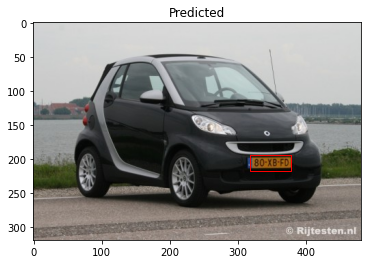

In [10]:
boxes, img = predict_once(r"C:\Users\midni\Desktop\School\INNO\opencv-anpr\license_plates\group3\029.jpg",
                          model, cfg, debug=True)

In [9]:
def Detect_And_Read_Plates(img, model, cfg, debug=False, plate_num=None, OCR="T", lang="plate_model"):
    boxes, img = predict_once(img, model, cfg)

    first_c = first_crops(img, boxes)

    total_speed = [0, 0]
    total_accuracy = [0, 0]

    for crop in first_c:
        second_crop = secondCrop(crop)
        contrasted_img = increase_contrast_2(increase_contrast_1(second_crop))
        contrasted_img = apply_brightness_contrast(contrasted_img, brightness=-50, contrast=30)

        if OCR == "T":
            start_time = time.time()
            plates = Tesseract_OCR(contrasted_img, lang)
            speed = round(time.time() - start_time, 3)
            print("Plates: " + str(plates))
            for plate in plate_num:
                plate = re.sub(r'[^\w]', '', plate)
                print(plate, [re.sub(r'[^\w]', '', x) for x in plates])
                max_accuracy = max([SequenceMatcher(None, plate, re.sub(r'[^\w]', '', x)).ratio() for x in plates])
                total_accuracy[0] += max_accuracy
                total_accuracy[1] += 1
                print("Max accuracy: " + str(max_accuracy))
            print("Speed: " + str(speed))
            print()
            total_speed[0] += speed
            total_speed[1] += 1
        elif OCR == "G":
            temp_img = Image.fromarray(contrasted_img)
            temp_img.save(r"./temp/temp_img.jpg")
            start_time = time.time()
            with io.open(r"./temp/temp_img.jpg", 'rb') as image_file:
                content = image_file.read()
                image = vision.Image(content=content)

                response = client.text_detection(image=image)
                texts = response.text_annotations
            if len(texts) > 0:
                plates = [z.description for z in texts]
                speed = round(time.time() - start_time, 3)
                print("Plates: " + str(plates))
                for plate in plate_num:
                    max_accuracy = max_accuracy = max([SequenceMatcher(None, plate, x).ratio() for x in plates])
                    total_accuracy[0] += max_accuracy
                    total_accuracy[1] += 1
                    print("Max accuracy: " + str(max_accuracy))
                print("Speed: " + str(speed))
                print()
                total_speed[0] += speed
                total_speed[1] += 1
        elif OCR == "O":
            temp_img = Image.fromarray(contrasted_img)
            temp_img.save(r"./temp/temp_img.jpg")
            jpeg_bytes = open(r"./temp/temp_img.jpg", "rb").read()
            start_time = time.time()
            results = alpr.recognize_array(jpeg_bytes)
            speed = round(time.time() - start_time, 3)
            total_speed[0] += speed
            total_speed[1] += 1
            print(results['results'], speed)

    return (total_speed, total_accuracy)

# Bepaling Threshold
Eigen tests op foto's: <br>
foto 1: 5, 7, 12, 13 <br>
foto 2: 10, 13, 14 <br>
foto 3: 3, 6 <br>
foto 4: 3, 12 <br>
foto 5: 12 <br>
foto 6: 11, 17 <br>
foto 7: 1, 4, 5, 7 <br>
foto 8: 2, 14 <br>
foto 9: 4, 16 <br> 

In [109]:
pic1 = [5, 7, 12, 13]
pic2 = [10, 13, 14]
pic3 = [3, 6]
pic4 = [3, 12]
pic5 = [12]
pic6 = [11, 17]
pic7 = [1, 4, 5, 7]
pic8 = [2, 14]
pic9 = [4, 16]

all_pics = [pic1, pic2, pic3, pic4, pic5, pic6, pic7, pic8, pic9]
minimum = []
maximum = []
for pic in all_pics:
    minimum.append(min(pic))
    maximum.append(max(pic))
print("minimum="+str(np.median(minimum)), "maximum="+str(np.median(maximum)))

minimum=4.0 maximum=13.0


In [10]:
def Tesseract_OCR(img, lang):
    im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, im_bw) = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    counter = 0
    plates = []
    ratios = []
    for i in range(20, 70, 5):
        im_bw = cv2.threshold(im_gray, thresh + i, 255, cv2.THRESH_BINARY)

        plate_crop = Image.fromarray(im_bw[1])
        new_size = tuple(14*x for x in plate_crop.size)
        resized_img = plate_crop.resize(new_size, Image.ANTIALIAS)

        text = pytesseract.image_to_string(resized_img, lang=lang, config='--psm 10')
        plates.append(re.sub('[\n-\x0c]',  '', text))
        # print("Detected license plate Number is:", text+" Iteration= "+str(counter))
        counter += 1
    plates = list(set(plates))
    return plates

6:5: F841 local variable 'ratios' is assigned to but never used


# Tesseract VS Google

In [11]:
path = r"C:/Users/midni/Desktop/School/INNO/opencv-anpr/license_plates/group3/0"
plates = [["56-TK-JL"], ["PJ-034-T"], ["07-NJB-5"], 
         ["17-HK-LG"], ["J-179-RT"], ["9-XHP-78"],
         ["76-XJ-XP"], ["TX-979-F"], ["skip"],
         ["skip"], ["skip"], ["24-XV-LZ"],
         ["TX-882-S"], ["92-RZ-XZ", "98-ST-XX"], ["29-JTF-7"],
         ["skip"], ["8-ZKX-27"], ["85-NB-XG"],
         ["64-PH-TH"], ["skip"], ["29-LJK-3"],
         ["G-499-KH"], ["KF-544-F"], ["PL-32-TG"],
         ["56-ZF-DL"], ["G-499-KH"], ["53-RGT-1"],
         ["GL-395-X"], ["80-XB-FD"],["ST-185-K", "GL-805-X", "5-XZV-10"],
         ["J-179-RT"], ["XT-567-K"], ["skip"],
         ["KD-362-J"], ["NJ-621-S"], ["9-ZNK-53"], 
         ["84-KLJ-9", "55-NZ-TV"], ["47-JR-LV"], ["31-PX-KR"],
         ["BX-41-PZ"], ["GX02 BCF"], ["H 786 POJ"]]

2:52: W291 trailing whitespace
3:10: E128 continuation line under-indented for visual indent
4:10: E128 continuation line under-indented for visual indent
5:10: E128 continuation line under-indented for visual indent
6:10: E128 continuation line under-indented for visual indent
7:10: E128 continuation line under-indented for visual indent
8:10: E128 continuation line under-indented for visual indent
9:10: E128 continuation line under-indented for visual indent
10:10: E128 continuation line under-indented for visual indent
11:10: E128 continuation line under-indented for visual indent
11:36: E231 missing whitespace after ','
12:10: E128 continuation line under-indented for visual indent
13:10: E128 continuation line under-indented for visual indent
13:51: W291 trailing whitespace
14:10: E128 continuation line under-indented for visual indent
15:10: E128 continuation line under-indented for visual indent


picture: 1
Plates: ['CS),', 'aN', 'a.', 'ON', '<a.', 'EN)', 'ES).', 'ES),', 'Ey,', '3)']
56TKJL ['CS', 'aN', 'a', 'ON', 'a', 'EN', 'ES', 'ES', 'Ey', '3']
Max accuracy: 0.0
Speed: 15.575

Plates: ['B61 KIL', '56TK-IL', '56 TK-SL', 'Se KIL', 'SETH SL', 'Be TK IL', 'Tai ele', 'Se SL', 'STK SL', '56-1K-SL']
56TKJL ['B61KIL', '56TKIL', '56TKSL', 'SeKIL', 'SETHSL', 'BeTKIL', 'Taiele', 'SeSL', 'STKSL', '561KSL']
Max accuracy: 0.8333333333333334
Speed: 4.52


picture: 2
Plates: ['a', 'rar', 'os', '°sC3s4', 'cs', '. sca', 's<', 'ceca']
PJ034T ['a', 'rar', 'os', 'sC3s4', 'cs', 'sca', 's', 'ceca']
Max accuracy: 0.36363636363636365
Speed: 5.485


picture: 3
Plates: ["'O7-NIB-5", '"07-K 15-5.', '07-4 I5-5', "'O7-K 5-5.", 'O7-NI5-5_', 'O7-NJ5-5', "'O7-NUB-S", 'O7-NIE-5', '107-NI5-5,']
07NJB5 ['O7NIB5', '07K155', '074I55', 'O7K55', 'O7NI55_', 'O7NJ55', 'O7NUBS', 'O7NIE5', '107NI55']
Max accuracy: 0.6666666666666666
Speed: 4.639


picture: 4
Plates: ['of -', 'FS', '“oe f=', 'ret', '——- 7!', 'Tad i ie'

Plates: ['rere 22', 'cafy 23', 'ers 2 t', 'intta 3', 'Feist', 'Fare?', 'rai sy 2 t', 'intta®', 'Peis 2 t']
J179RT ['rere22', 'cafy23', 'ers2t', 'intta3', 'Feist', 'Fare', 'raisy2t', 'intta', 'Peis2t']
Max accuracy: 0.0
Speed: 4.357


picture: 32
Plates: ['[xT 7567-4)', 'PXT-567-K)', '/XT-567-K)', '[XT-567-K)', '[xT -567-K]', 'XT-567-K)', '[XT -567-K)']
XT567K ['xT75674', 'PXT567K', 'XT567K', 'XT567K', 'xT567K', 'XT567K', 'XT567K']
Max accuracy: 1.0
Speed: 4.675


picture: 33
skipping..
picture: 34
Plates: ['KD-363-7]', 'KD-367-7]', 'KD-362-3)', 'KD-362-J]', 'KD-362-9)', 'KD-36-J]', 'KD-362-7)', 'KD:362-J}', 'KD362-J]']
KD362J ['KD3637', 'KD3677', 'KD3623', 'KD362J', 'KD3629', 'KD36J', 'KD3627', 'KD362J', 'KD362J']
Max accuracy: 1.0
Speed: 5.422


picture: 35

picture: 36

picture: 37
Plates: ['[5 3:SKiK!', '[5 3eSK:K', 'LB3SK:A.', 'FB STSKA', 'EB 3eSKiK!', '[5 3°SK:ki', 'S525 RM', 'tSa:SKckt', 'PB 3-SK:K!', 'PS3:SKck!']
84KLJ9 ['53SKiK', '53eSKK', 'LB3SKA', 'FBSTSKA', 'EB3eSKiK', '53SK

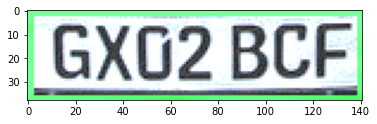

9:17: W291 trailing whitespace
12:80: E501 line too long (112 > 79 characters)
15:1: W293 blank line contains whitespace
19:23: E225 missing whitespace around operator
20:27: E225 missing whitespace around operator


In [30]:
tesseract_speed = 0
tesseract_accuracy = 0
tesseract_speed_counter = 0
tesseract_accuracy_counter = 0
for i in range(42):
    print("picture: "+str(i+1))
    if plates[i][0] == "skip":
        print("skipping..")
        continue 
    pic = str(i+1).zfill(2)
    pic_path = path + pic + ".jpg"
    result = Detect_And_Read_Plates(pic_path, model, cfg, debug=False, OCR='T', plate_num=plates[i], lang='eng')
    tesseract_speed += result[0][0]
    tesseract_speed_counter += result[0][1]
    
    tesseract_accuracy += result[1][0]
    tesseract_accuracy_counter += result[1][1]
    print()
print("Average time: "+ str(tesseract_speed/tesseract_speed_counter))
print("Average accuracy: "+ str(tesseract_accuracy/tesseract_accuracy_counter))

picture: 1
Plates: ['D2', 'BGT', '2', 'DZ', 'BGS', 'OTS', 'BZ']
56TKJL ['D2', 'BGT', '2', 'DZ', 'BGS', 'OTS', 'BZ']
Max accuracy: 0.2222222222222222
Speed: 15.426

Plates: ['', '886SSSG', 'ZZ', '8888S', '86 36LF', 'GEC', 'SZC', '86S', 'BZ']
56TKJL ['', '886SSSG', 'ZZ', '8888S', '8636LF', 'GEC', 'SZC', '86S', 'BZ']
Max accuracy: 0.3333333333333333
Speed: 4.772


picture: 2
Plates: ['ZZ', 'F 9A', 'Z 9Z ZS', 'DZ', 'FZ', 'EZ']
PJ034T ['ZZ', 'F9A', 'Z9ZZS', 'DZ', 'FZ', 'EZ']
Max accuracy: 0.0
Speed: 5.75


picture: 3
Plates: ['ZZ', 'L0CGO8G', '02 087', '1 ZZ', 'LBAAG8T8', '02 SU8T8', 'LBC XO828', '06 GO8X']
07NJB5 ['ZZ', 'L0CGO8G', '02087', '1ZZ', 'LBAAG8T8', '02SU8T8', 'LBCXO828', '06GO8X']
Max accuracy: 0.36363636363636365
Speed: 5.023


picture: 4
Plates: ['AC 0 JZ9G', 'ZC7ZZ', 'VZCWIZ 9 Z', 'CC7C0', 'DZ', 'CZ', '3ZF JZ LG', 'RZ', 'BZ', 'YYW 9 LZ']
17HKLG ['AC0JZ9G', 'ZC7ZZ', 'VZCWIZ9Z', 'CC7C0', 'DZ', 'CZ', '3ZFJZLG', 'RZ', 'BZ', 'YYW9LZ']
Max accuracy: 0.3076923076923077
Speed: 5.005



Plates: ['', '8', 'DZ', 'LZ', '8S']
84KLJ9 ['', '8', 'DZ', 'LZ', '8S']
Max accuracy: 0.2857142857142857
55NZTV ['', '8', 'DZ', 'LZ', '8S']
Max accuracy: 0.25
Speed: 6.086


picture: 38
Plates: ['ZZ', 'X2 382LZ', 'EH', 'X73 L2', '7 JB1L2', '7 JB1L9']
47JRLV ['ZZ', 'X2382LZ', 'EH', 'X73L2', '7JB1L2', '7JB1L9']
Max accuracy: 0.5
Speed: 5.168

Plates: ['62381 LR', 'QZ EEL', 'Z0ILLE', '223BP LP', 'S68SE1L5', '6S2BR L5', '5INX LR', '22 0F LI', 'EZ EE 68', '2248 LI']
47JRLV ['62381LR', 'QZEEL', 'Z0ILLE', '223BPLP', 'S68SE1L5', '6S2BRL5', '5INXLR', '220FLI', 'EZEE68', '2248LI']
Max accuracy: 0.3333333333333333
Speed: 5.278

Plates: ['ZS 4', 'EZ', 'CAG 4', 'SS', 'EZ 4', 'ZZ 4', 'ZAG 4']
47JRLV ['ZS4', 'EZ', 'CAG4', 'SS', 'EZ4', 'ZZ4', 'ZAG4']
Max accuracy: 0.2222222222222222
Speed: 5.15

Plates: ['DZ', 'DL', 'DE']
47JRLV ['DZ', 'DL', 'DE']
Max accuracy: 0.25
Speed: 4.977


picture: 39
Plates: ['0004', '05', '0K', '855', '0E55', '80EJ', '0RJ']
31PXKR ['0004', '05', '0K', '855', '0E55', '80EJ', '

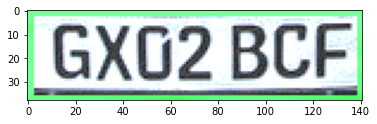

9:17: W291 trailing whitespace
12:80: E501 line too long (120 > 79 characters)
15:1: W293 blank line contains whitespace
19:23: E225 missing whitespace around operator
20:27: E225 missing whitespace around operator


In [31]:
tesseract_speed = 0
tesseract_accuracy = 0
tesseract_speed_counter = 0
tesseract_accuracy_counter = 0
for i in range(42):
    print("picture: "+str(i+1))
    if plates[i][0] == "skip":
        print("skipping..")
        continue 
    pic = str(i+1).zfill(2)
    pic_path = path + pic + ".jpg"
    result = Detect_And_Read_Plates(pic_path, model, cfg, debug=False, OCR='T', plate_num=plates[i], lang='plate_model')
    tesseract_speed += result[0][0]
    tesseract_speed_counter += result[0][1]
    
    tesseract_accuracy += result[1][0]
    tesseract_accuracy_counter += result[1][1]
    print()
print("Average time: "+ str(tesseract_speed/tesseract_speed_counter))
print("Average accuracy: "+ str(tesseract_accuracy/tesseract_accuracy_counter))

picture: 1
Plates: ['177', '137L', 'L37L', 'LL', 'LBL', 'L3FL', 'L31L', '1T71U', '1T33L']
56TKJL ['177', '137L', 'L37L', 'LL', 'LBL', 'L3FL', 'L31L', '1T71U', '1T33L']
Max accuracy: 0.36363636363636365
Speed: 16.182

Plates: ['ZZ73GJD', 'ZZ7G3Z', 'ELEL3E', '7T63JE', 'E7TZ3E', 'ELLE', '777373E', 'JC 3Z2JZ', 'STE3E', 'ZLL3E']
56TKJL ['ZZ73GJD', 'ZZ7G3Z', 'ELEL3E', '7T63JE', 'E7TZ3E', 'ELLE', '777373E', 'JC3Z2JZ', 'STE3E', 'ZLL3E']
Max accuracy: 0.3333333333333333
Speed: 4.751


picture: 2
Plates: ['17EZTFF', 'FZZEF7', '1F7BFFT', 'F7EFF7', 'ZZZZED', 'FZZZEEFFT', 'F7ECL7F7', '17ZLFFT', '17E5FF', 'FZZEE FT']
PJ034T ['17EZTFF', 'FZZEF7', '1F7BFFT', 'F7EFF7', 'ZZZZED', 'FZZZEEFFT', 'F7ECL7F7', '17ZLFFT', '17E5FF', 'FZZEEFT']
Max accuracy: 0.15384615384615385
Speed: 6.158


picture: 3
Plates: ['ZRTZ3E7', 'ZC 737TZ', 'LCZ7378T7', 'LC777STF7', 'LEZ 36TZ7', 'ZZ 7', 'ZZU7ZULEZ7', 'LE7TELZ7', 'GZ TJJ87S', 'JQ7 II357TS']
07NJB5 ['ZRTZ3E7', 'ZC737TZ', 'LCZ7378T7', 'LC777STF7', 'LEZ36TZ7', 'ZZ7', 'ZZU

Plates: ['LB TZE7 L', 'LBYZAL7 LE', 'L1ULLEZJI', 'L1TZYPF LI', 'L FLL 1EF3E', 'LBULEFZL', 'LL SFL', 'E35 Z3Z', 'LBYZLL7TL', 'LL LLL']
ST185K ['LBTZE7L', 'LBYZAL7LE', 'L1ULLEZJI', 'L1TZYPFLI', 'LFLL1EF3E', 'LBULEFZL', 'LLSFL', 'E35Z3Z', 'LBYZLL7TL', 'LLLLL']
Max accuracy: 0.18181818181818182
GL805X ['LBTZE7L', 'LBYZAL7LE', 'L1ULLEZJI', 'L1TZYPFLI', 'LFLL1EF3E', 'LBULEFZL', 'LLSFL', 'E35Z3Z', 'LBYZLL7TL', 'LLLLL']
Max accuracy: 0.18181818181818182
5XZV10 ['LBTZE7L', 'LBYZAL7LE', 'L1ULLEZJI', 'L1TZYPFLI', 'LFLL1EF3E', 'LBULEFZL', 'LLSFL', 'E35Z3Z', 'LBYZLL7TL', 'LLLLL']
Max accuracy: 0.3333333333333333
Speed: 7.369


picture: 31
Plates: ['LZZZZZZF7', 'EZ7ZZT', 'LZZZZZ ZZ', 'EZFZZT', 'EZF7ZT', 'FZ7ZL77', 'EZLZZT', 'ZEFEFZF', 'FZ7ZZ7']
J179RT ['LZZZZZZF7', 'EZ7ZZT', 'LZZZZZZZ', 'EZFZZT', 'EZF7ZT', 'FZ7ZL77', 'EZLZZT', 'ZEFEFZF', 'FZ7ZZ7']
Max accuracy: 0.3333333333333333
Speed: 6.457


picture: 32
Plates: ['ZZDLZZZ', 'LLE7TTZ', 'CCT ZK', '111777', 'EZRZLZ7Z', 'Z7LZZZ', '7SZZ3ZZZ', 'FTF 777'

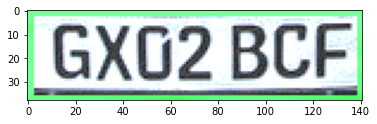

9:17: W291 trailing whitespace
12:120: E501 line too long (122 > 119 characters)
15:1: W293 blank line contains whitespace
19:23: E225 missing whitespace around operator
20:27: E225 missing whitespace around operator


In [16]:
tesseract_speed = 0
tesseract_accuracy = 0
tesseract_speed_counter = 0
tesseract_accuracy_counter = 0
for i in range(42):
    print("picture: "+str(i+1))
    if plates[i][0] == "skip":
        print("skipping..")
        continue 
    pic = str(i+1).zfill(2)
    pic_path = path + pic + ".jpg"
    result = Detect_And_Read_Plates(pic_path, model, cfg, debug=False, OCR='T', plate_num=plates[i], lang='plate_model_1')
    tesseract_speed += result[0][0]
    tesseract_speed_counter += result[0][1]
    
    tesseract_accuracy += result[1][0]
    tesseract_accuracy_counter += result[1][1]
    print()
print("Average time: "+ str(tesseract_speed/tesseract_speed_counter))
print("Average accuracy: "+ str(tesseract_accuracy/tesseract_accuracy_counter))

picture: 1
Plates: ['IT', 'IT 1', 'GL', 'I TS', 'YT', 'I TL', 'JL', 'TL']
56TKJL ['IT', 'IT1', 'GL', 'ITS', 'YT', 'ITL', 'JL', 'TL']
Max accuracy: 0.5
Speed: 16.143

Plates: ['7 TF 2', 'ZS', 'SS TS 5', '7 ZS', '2S', '3 ZZ', 'TS', '522', 'ZG', 'ZZ 5']
56TKJL ['7TF2', 'ZS', 'SSTS5', '7ZS', '2S', '3ZZ', 'TS', '522', 'ZG', 'ZZ5']
Max accuracy: 0.25
Speed: 4.517


picture: 2
Plates: ['SZ SS', '7 Z ZS', '7 ZS', 'S72 SS', '7 Z SS', '232 SS', 'YZ ZZ', '72 SS', 'ZZ 2S']
PJ034T ['SZSS', '7ZZS', '7ZS', 'S72SS', '7ZSS', '232SS', 'YZZZ', '72SS', 'ZZ2S']
Max accuracy: 0.18181818181818182
Speed: 5.425


picture: 3
Plates: ['ECO TTS', 'CZ', 'O7 KX TS', 'SU SZ 2', 'ZC TS', 'GZ STS', '7 XK STS', 'LZ SS', '3 SZ', 'IU ZT']
07NJB5 ['ECOTTS', 'CZ', 'O7KXTS', 'SUSZ2', 'ZCTS', 'GZSTS', '7XKSTS', 'LZSS', '3SZ', 'IUZT']
Max accuracy: 0.16666666666666666
Speed: 4.76


picture: 4
Plates: ['YY YT 2', 'ZS', 'TZ CT CG', 'XC', 'TY MIT ZG', 'IZ TT', 'TC YT ZS', 'TS 2', 'ZT YT 2', 'TT']
17HKLG ['YYYT2', 'ZS', 'TZCTCG',

Plates: ['3 3Z', 'SS', '2', '2 2', 'ZZ', 'SZ', 'JT CZ', '32']
84KLJ9 ['33Z', 'SS', '2', '22', 'ZZ', 'SZ', 'JTCZ', '32']
Max accuracy: 0.2
55NZTV ['33Z', 'SS', '2', '22', 'ZZ', 'SZ', 'JTCZ', '32']
Max accuracy: 0.25
Speed: 7.102

Plates: ['IJ', '', 'JJG', 'TLS', 'TT', '1', '8JJJD', 'TD', '5JJIL']
84KLJ9 ['IJ', '', 'JJG', 'TLS', 'TT', '1', '8JJJD', 'TD', '5JJIL']
Max accuracy: 0.36363636363636365
55NZTV ['IJ', '', 'JJG', 'TLS', 'TT', '1', '8JJJD', 'TD', '5JJIL']
Max accuracy: 0.25
Speed: 5.699


picture: 38
Plates: ['ZS', '73 JRTLV', '7 JR TV', '7 TTC', 'CLZG', '7 JK TV', '473 JRTL9', '7 JR LV']
47JRLV ['ZS', '73JRTLV', '7JRTV', '7TTC', 'CLZG', '7JKTV', '473JRTL9', '7JRLV']
Max accuracy: 0.9090909090909091
Speed: 4.545

Plates: ['TTT LP', '2 GP LP', 'TP LP', '7 JP LR', 'Z ZZ L7', 'EZ EZ', 'J N9 LP', 'ZS JP LP', '0 LP', 'ZZ']
47JRLV ['TTTLP', '2GPLP', 'TPLP', '7JPLR', 'ZZZL7', 'EZEZ', 'JN9LP', 'ZSJPLP', '0LP', 'ZZ']
Max accuracy: 0.5454545454545454
Speed: 4.127

Plates: ['TZ 6', 'EF TZ 2'

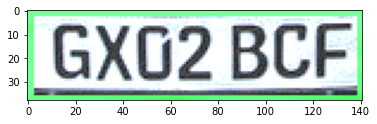

9:17: W291 trailing whitespace
12:120: E501 line too long (122 > 119 characters)
15:1: W293 blank line contains whitespace
19:23: E225 missing whitespace around operator
20:27: E225 missing whitespace around operator


In [12]:
tesseract_speed = 0
tesseract_accuracy = 0
tesseract_speed_counter = 0
tesseract_accuracy_counter = 0
for i in range(42):
    print("picture: "+str(i+1))
    if plates[i][0] == "skip":
        print("skipping..")
        continue 
    pic = str(i+1).zfill(2)
    pic_path = path + pic + ".jpg"
    result = Detect_And_Read_Plates(pic_path, model, cfg, debug=False, OCR='T', plate_num=plates[i], lang='plate_model_2')
    tesseract_speed += result[0][0]
    tesseract_speed_counter += result[0][1]
    
    tesseract_accuracy += result[1][0]
    tesseract_accuracy_counter += result[1][1]
    print()
print("Average time: "+ str(tesseract_speed/tesseract_speed_counter))
print("Average accuracy: "+ str(tesseract_accuracy/tesseract_accuracy_counter))

picture: 1
Plates: ['CNML', '€N3L', 'S N', 'SN9L', 'SSNL', ' N', 'SNL']
56TKJL ['CNML', 'N3L', 'SN', 'SN9L', 'SSNL', 'N', 'SNL']
Max accuracy: 0.2222222222222222
Speed: 18.39

Plates: ['56 1K 3L', '56TK 3L', 'F6 TK 3L', '56 TK 3L', 'E5 TK 3L', '56 TR JL', '55TK 3L']
56TKJL ['561K3L', '56TK3L', 'F6TK3L', '56TK3L', 'E5TK3L', '56TRJL', '55TK3L']
Max accuracy: 0.8333333333333334
Speed: 5.846


picture: 2
Plates: ['F  C SE 3', 'K 5L38 3', 'F  CSE 3', 'R 5 C38 3', 'F - C2£ 3', 'F SC 2E 3', 'R 5 CT28 3', 'B 5L38 3', 'E 5 C2S 3']
PJ034T ['FCSE3', 'K5L383', 'FCSE3', 'R5C383', 'FC23', 'FSC2E3', 'R5CT283', 'B5L383', 'E5C2S3']
Max accuracy: 0.2
Speed: 6.107


picture: 3
Plates: ['07 NJB 5', 'Q07 X I5 3', '07 RJ5 5', '07 X73 S', ' 07 X I5 5', 'Q7 X73 5', '07 XJ5 5', '07 KJB 5']
07NJB5 ['07NJB5', 'Q07XI53', '07RJ55', '07X73S', '07XI55', 'Q7X735', '07XJ55', '07KJB5']
Max accuracy: 1.0
Speed: 5.043


picture: 4
Plates: ['T € L Z', ' 1 Z', 'FF 4 L ZI', 'FF  €1 ZI', 'T 1 Z', 'TF — T3 Z', 'C —8  Z', 'T €

Plates: ['IF ZZ Z X 2', 'F E13 2 1', 'FZZ P 2 1', 'F EZ 2 2 1', 'FZ2  Z 1', 'IF ZZ Z X 1', 'FE1 Z Z 1', 'F Z£ Z 2 1', 'F E17 2 1', 'F27 7 X17']
J179RT ['IFZZZX2', 'FE1321', 'FZZP21', 'FEZ221', 'FZ2Z1', 'IFZZZX1', 'FE1ZZ1', 'FZZ21', 'FE1721', 'F277X17']
Max accuracy: 0.3333333333333333
Speed: 4.24


picture: 32
Plates: ['JXT 56ZKJ', ' XT 567 KJ', 'IXT 56ZKJ', '7XT 567 KJ', '[XT 56ZK', ' XT 567 LJ', ' XT 56ZK', '[XT 56ZKJ']
XT567K ['JXT56ZKJ', 'XT567KJ', 'IXT56ZKJ', '7XT567KJ', 'XT56ZK', 'XT567LJ', 'XT56ZK', 'XT56ZKJ']
Max accuracy: 0.9230769230769231
Speed: 4.911


picture: 33
skipping..
picture: 34
Plates: ['KD 362 7J', 'KD 3527J', 'KD38Z7I', 'KD 35277J', 'KD 36Z7J', 'KL38Z7I']
KD362J ['KD3627J', 'KD3527J', 'KD38Z7I', 'KD35277J', 'KD36Z7J', 'KL38Z7I']
Max accuracy: 0.9230769230769231
Speed: 5.43


picture: 35

picture: 36

picture: 37
Plates: ['53 SKA', '153 SKA', 'I53 SKAI', 'I53 SKK', 'I53 SK A1', 'I53 SK R', 'I535KK', 'I53:SKK', 'I535KAI', 'I535SKKI']
84KLJ9 ['53SKA', '153SKA', 'I53

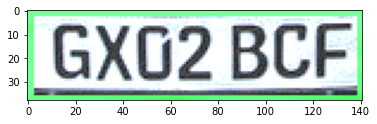

9:17: W291 trailing whitespace
12:120: E501 line too long (122 > 119 characters)
15:1: W293 blank line contains whitespace
19:23: E225 missing whitespace around operator
20:27: E225 missing whitespace around operator


In [13]:
tesseract_speed = 0
tesseract_accuracy = 0
tesseract_speed_counter = 0
tesseract_accuracy_counter = 0
for i in range(42):
    print("picture: "+str(i+1))
    if plates[i][0] == "skip":
        print("skipping..")
        continue 
    pic = str(i+1).zfill(2)
    pic_path = path + pic + ".jpg"
    result = Detect_And_Read_Plates(pic_path, model, cfg, debug=False, OCR='T', plate_num=plates[i], lang='plate_model_3')
    tesseract_speed += result[0][0]
    tesseract_speed_counter += result[0][1]
    
    tesseract_accuracy += result[1][0]
    tesseract_accuracy_counter += result[1][1]
    print()
print("Average time: "+ str(tesseract_speed/tesseract_speed_counter))
print("Average accuracy: "+ str(tesseract_accuracy/tesseract_accuracy_counter))

picture: 1
Plates: ['SZL', 'CN7L', 'CN9L', 'S8L', 'CN5L', 'SB5L', 'SBL', 'S9L', 'SHL']
56TKJL ['SZL', 'CN7L', 'CN9L', 'S8L', 'CN5L', 'SB5L', 'SBL', 'S9L', 'SHL']
Max accuracy: 0.4
Speed: 15.543

Plates: ['E5 TK 3L', '56 TK 3L', '56TK 3L', '56 TK 3U', '55TK 3L', '55 TK 3L', 'F6 TK 3L']
56TKJL ['E5TK3L', '56TK3L', '56TK3L', '56TK3U', '55TK3L', '55TK3L', 'F6TK3L']
Max accuracy: 0.8333333333333334
Speed: 4.945


picture: 2
Plates: ['E 5C38 3', 'P 5Z38 3', 'F S C2£ 3', 'F 2 C3E 3', 'FE 5 C28 3', 'E5Z38 3', 'F 2 C SE 3', 'E 5 C38 3', 'F 2 C ZE 3', 'F - C2£ 3']
PJ034T ['E5C383', 'P5Z383', 'FSC23', 'F2C3E3', 'FE5C283', 'E5Z383', 'F2CSE3', 'E5C383', 'F2CZE3', 'FC23']
Max accuracy: 0.3333333333333333
Speed: 5.861


picture: 3
Plates: [' Q7 RJ5 5', ' 07 X J5 5', '07 RJ5 5', '07 X7S 5', ' 07 XJ5 5', '07 XJ5 5', '07 KJB 5', '07 X73 5', '07 RJB 5']
07NJB5 ['Q7RJ55', '07XJ55', '07RJ55', '07X7S5', '07XJ55', '07XJ55', '07KJB5', '07X735', '07RJB5']
Max accuracy: 0.8333333333333334
Speed: 5.218


picture

Plates: ['I ZL Z Z1', 'F27 Z Z7', 'IL ZZ Z Z 1', 'IL ZZ Z Z 4', 'I Z2 7 Z 1', 'FZ1 Z Z1', 'FZZ Z Z 1', 'J ZZ Z Z 1', '5 ZZ Z 24']
J179RT ['IZLZZ1', 'F27ZZ7', 'ILZZZZ1', 'ILZZZZ4', 'IZ27Z1', 'FZ1ZZ1', 'FZZZZ1', 'JZZZZ1', '5ZZZ24']
Max accuracy: 0.3333333333333333
Speed: 4.446


picture: 32
Plates: [' XT 567 LJ', 'XT 567 LJ', 'XT 567 KJ', ' XT 56ZKJ', 'JXT S6ZKJ', ' XT 567 UJ', 'IXT 56ZKJ', '1XT 56ZKJ']
XT567K ['XT567LJ', 'XT567LJ', 'XT567KJ', 'XT56ZKJ', 'JXTS6ZKJ', 'XT567UJ', 'IXT56ZKJ', '1XT56ZKJ']
Max accuracy: 0.9230769230769231
Speed: 5.155


picture: 33
skipping..
picture: 34
Plates: ['XD 36Z71', 'XD 362 7J', 'KL3EZ7I', 'KD 36Z 7J', 'XD 35Z7', 'KD3EZ7I', 'XD3SZ7I', 'XD 36Z7', 'KD 362 7J', 'KD3SZ7I']
KD362J ['XD36Z71', 'XD3627J', 'KL3EZ7I', 'KD36Z7J', 'XD35Z7', 'KD3EZ7I', 'XD3SZ7I', 'XD36Z7', 'KD3627J', 'KD3SZ7I']
Max accuracy: 0.9230769230769231
Speed: 5.769


picture: 35

picture: 36

picture: 37
Plates: [' 53 SK K', 'I53 SKKI', ' 53 SKR', ' 53 SKKJ', 'I53 SKK', 'I535SKKI', '153SK

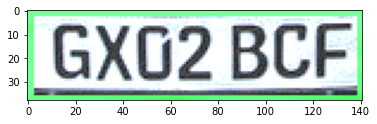

9:17: W291 trailing whitespace
12:120: E501 line too long (122 > 119 characters)
15:1: W293 blank line contains whitespace
19:23: E225 missing whitespace around operator
20:27: E225 missing whitespace around operator


In [13]:
tesseract_speed = 0
tesseract_accuracy = 0
tesseract_speed_counter = 0
tesseract_accuracy_counter = 0
for i in range(42):
    print("picture: "+str(i+1))
    if plates[i][0] == "skip":
        print("skipping..")
        continue 
    pic = str(i+1).zfill(2)
    pic_path = path + pic + ".jpg"
    result = Detect_And_Read_Plates(pic_path, model, cfg, debug=False, OCR='T', plate_num=plates[i], lang='plate_model_4')
    tesseract_speed += result[0][0]
    tesseract_speed_counter += result[0][1]
    
    tesseract_accuracy += result[1][0]
    tesseract_accuracy_counter += result[1][1]
    print()
print("Average time: "+ str(tesseract_speed/tesseract_speed_counter))
print("Average accuracy: "+ str(tesseract_accuracy/tesseract_accuracy_counter))

picture: 1
Plates: ['6SG1', '6S1', '6S', 'EX', '6', '61']
56TKJL ['6SG1', '6S1', '6S', 'EX', '6', '61']
Max accuracy: 0.2857142857142857
Speed: 16.744

Plates: ['5TK3L', 'E7K3L', '3ATKJL', 'E5TK 9L', '8 TKJL', '6 TK 3L', '3ETK3L', '6 TK3L']
56TKJL ['5TK3L', 'E7K3L', '3ATKJL', 'E5TK9L', '8TKJL', '6TK3L', '3ETK3L', '6TK3L']
Max accuracy: 0.7272727272727273
Speed: 5.218


picture: 2
Plates: ['B E', 'E  E', 'Z ZE', 'B 3', 'E E', 'E Z GE', 'Z Z', 'B 6', 'E 6Z', 'E CE']
PJ034T ['BE', 'EE', 'ZZE', 'B3', 'EE', 'EZGE', 'ZZ', 'B6', 'E6Z', 'ECE']
Max accuracy: 0.25
Speed: 6.153


picture: 3
Plates: [' 7 7E', '07 BLJB 5', 'G7 7ZZ', '07J55', 'O7 JB 5', '07 JB5', 'O7 EL1B5', '07 IJB 5', 'O7 XJ55']
07NJB5 ['77E', '07BLJB5', 'G77ZZ', '07J55', 'O7JB5', '07JB5', 'O7EL1B5', '07IJB5', 'O7XJ55']
Max accuracy: 0.9090909090909091
Speed: 5.361


picture: 4
Plates: ['F  LZ', '46 CZ', 'F E LZ', 'F Z', 'I', ' ZZ7', '7 I', '4', ' I']
17HKLG ['FLZ', '46CZ', 'FELZ', 'FZ', 'I', 'ZZ7', '7I', '4', 'I']
Max accuracy: 0


picture: 36

picture: 37
Plates: ['B36KK', '53GKK', 'B348K', '535 K', 'IB348K', '536KK', 'I5348KK', 'B3SKA', 'B3GK', 'E236K']
84KLJ9 ['B36KK', '53GKK', 'B348K', '535K', 'IB348K', '536KK', 'I5348KK', 'B3SKA', 'B3GK', 'E236K']
Max accuracy: 0.36363636363636365
55NZTV ['B36KK', '53GKK', 'B348K', '535K', 'IB348K', '536KK', 'I5348KK', 'B3SKA', 'B3GK', 'E236K']
Max accuracy: 0.4
Speed: 5.038

Plates: ['84KL', '84K9', '87L', '8KL9', '84KL9', '88KL9', '8ZKL9']
84KLJ9 ['84KL', '84K9', '87L', '8KL9', '84KL9', '88KL9', '8ZKL9']
Max accuracy: 0.9090909090909091
55NZTV ['84KL', '84K9', '87L', '8KL9', '84KL9', '88KL9', '8ZKL9']
Max accuracy: 0.18181818181818182
Speed: 7.266

Plates: ['', 'E', 'I5', '7', ' 9']
84KLJ9 ['', 'E', 'I5', '7', '9']
Max accuracy: 0.2857142857142857
55NZTV ['', 'E', 'I5', '7', '9']
Max accuracy: 0.25
Speed: 5.936


picture: 38
Plates: ['A7JI2 TJ', 'A7J 1W', 'A7JIL 1W', '47JR LV', 'A7JR J', '47JIZ 1J', '477JIL 1W']
47JRLV ['A7JI2TJ', 'A7J1W', 'A7JIL1W', '47JRLV', 'A7JRJ', '4

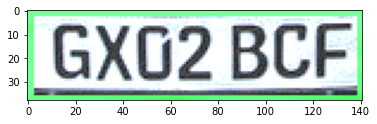

9:17: W291 trailing whitespace
12:120: E501 line too long (122 > 119 characters)
15:1: W293 blank line contains whitespace
19:23: E225 missing whitespace around operator
20:27: E225 missing whitespace around operator


In [12]:
tesseract_speed = 0
tesseract_accuracy = 0
tesseract_speed_counter = 0
tesseract_accuracy_counter = 0
for i in range(42):
    print("picture: "+str(i+1))
    if plates[i][0] == "skip":
        print("skipping..")
        continue 
    pic = str(i+1).zfill(2)
    pic_path = path + pic + ".jpg"
    result = Detect_And_Read_Plates(pic_path, model, cfg, debug=False, OCR='T', plate_num=plates[i], lang='plate_model_5')
    tesseract_speed += result[0][0]
    tesseract_speed_counter += result[0][1]
    
    tesseract_accuracy += result[1][0]
    tesseract_accuracy_counter += result[1][1]
    print()
print("Average time: "+ str(tesseract_speed/tesseract_speed_counter))
print("Average accuracy: "+ str(tesseract_accuracy/tesseract_accuracy_counter))

picture: 1
Plates: [' L', 'CS L', 'S L']
56TKJL ['L', 'CSL', 'SL']
Max accuracy: 0.2857142857142857
Speed: 14.833

Plates: ['56 TK3L', '55TI3L', '6 TK5L', 'E5 TK3L', '56 TY 3L', '55TK3L', '55 TK3L', '5 TK3L']
56TKJL ['56TK3L', '55TI3L', '6TK5L', 'E5TK3L', '56TY3L', '55TK3L', '55TK3L', '5TK3L']
Max accuracy: 0.8333333333333334
Speed: 4.725


picture: 2
Plates: ['Z 5 ZDE5 Z', 'X ZZE', 'E 5 Z3E Z', 'Z Z3E Z', 'E 5UE', 'E 5 Z5 Z', 'E ZSE 3', 'E 5ZE', 'E 5 I2E Z', '25 Z25 T']
PJ034T ['Z5ZDE5Z', 'XZZE', 'E5Z3EZ', 'ZZ3EZ', 'E5UE', 'E5Z5Z', 'EZSE3', 'E5ZE', 'E5I2EZ', '25Z25T']
Max accuracy: 0.18181818181818182
Speed: 5.732


picture: 3
Plates: ['O7 IJE 5', 'O7 37Z5', '0O7 IJB 5', '07 X J5 5', '07 XJ5 5', '07 I75Z', 'O7 X 15 5', '07 KJ5 5', 'D7 KJ5 5', 'C7 3L55']
07NJB5 ['O7IJE5', 'O737Z5', '0O7IJB5', '07XJ55', '07XJ55', '07I75Z', 'O7X155', '07KJ55', 'D7KJ55', 'C73L55']
Max accuracy: 0.7692307692307693
Speed: 5.005


picture: 4
Plates: ['1', 'F Y LZ', 'FV Z1', ' ZI', 'TF  L Z', 'F Z', 'V Z1', '

Plates: ['IXT 567 K', 'XT 567 K', 'XT 567 KJ']
XT567K ['IXT567K', 'XT567K', 'XT567KJ']
Max accuracy: 1.0
Speed: 4.926


picture: 33
skipping..
picture: 34
Plates: ['KD 36ZTJ', 'XD 3577J', 'KD 362TJ', 'KD 35ZTJ', 'KD 3E7I', 'KD 3EZTI', 'KD 35TJ']
KD362J ['KD36ZTJ', 'XD3577J', 'KD362TJ', 'KD35ZTJ', 'KD3E7I', 'KD3EZTI', 'KD35TJ']
Max accuracy: 0.9230769230769231
Speed: 5.422


picture: 35

picture: 36

picture: 37
Plates: ['E3SKK', 'B3SKZR', '5335 KZKI', 'E3SKI', 'B32S KK', '5335 KZKLI', '532SK', '53 SKK', '1B3SKR', '53SKK']
84KLJ9 ['E3SKK', 'B3SKZR', '5335KZKI', 'E3SKI', 'B32SKK', '5335KZKLI', '532SK', '53SKK', '1B3SKR', '53SKK']
Max accuracy: 0.26666666666666666
55NZTV ['E3SKK', 'B3SKZR', '5335KZKI', 'E3SKI', 'B32SKK', '5335KZKLI', '532SK', '53SKK', '1B3SKR', '53SKK']
Max accuracy: 0.42857142857142855
Speed: 4.663

Plates: ['54KL', '54KLJ 9', '87KLJ9', '5KLJ', '5ZKLJ 9', '5ZKL 9', '84KLJ 9', '34KL', '84KL9', '84KL 9']
84KLJ9 ['54KL', '54KLJ9', '87KLJ9', '5KLJ', '5ZKLJ9', '5ZKL9', '84KLJ

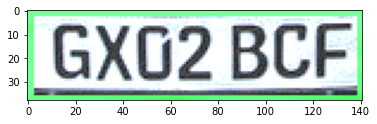

9:17: W291 trailing whitespace
12:120: E501 line too long (122 > 119 characters)
15:1: W293 blank line contains whitespace
19:23: E225 missing whitespace around operator
20:27: E225 missing whitespace around operator


In [13]:
tesseract_speed = 0
tesseract_accuracy = 0
tesseract_speed_counter = 0
tesseract_accuracy_counter = 0
for i in range(42):
    print("picture: "+str(i+1))
    if plates[i][0] == "skip":
        print("skipping..")
        continue 
    pic = str(i+1).zfill(2)
    pic_path = path + pic + ".jpg"
    result = Detect_And_Read_Plates(pic_path, model, cfg, debug=False, OCR='T', plate_num=plates[i], lang='plate_model_6')
    tesseract_speed += result[0][0]
    tesseract_speed_counter += result[0][1]
    
    tesseract_accuracy += result[1][0]
    tesseract_accuracy_counter += result[1][1]
    print()
print("Average time: "+ str(tesseract_speed/tesseract_speed_counter))
print("Average accuracy: "+ str(tesseract_accuracy/tesseract_accuracy_counter))

picture: 1
Plates: ['56-TK-JL\n', '56-TK-JL']
Max accuracy: 1.0
Speed: 0.62


picture: 2
Plates: ['7C34-\n', '7C34-']
Max accuracy: 0.46153846153846156
Speed: 0.507


picture: 3
Plates: ['07-NJB-5\n', '07-NJB-5']
Max accuracy: 1.0
Speed: 0.552


picture: 4

picture: 5
Plates: ['179-\n', '179-']
Max accuracy: 0.6666666666666666
Speed: 0.725


picture: 6
Plates: ['9-ХНР-78\n', '9-ХНР-78']
Max accuracy: 0.625
Speed: 0.609

Plates: ['9-ХНР-78\n', '9-ХНР-78']
Max accuracy: 0.625
Speed: 0.591


picture: 7
Plates: ['76-XFP\n', '76-XFP']
Max accuracy: 0.7142857142857143
Speed: 0.563


picture: 8
Plates: ['TX-979-F\n', 'TX-979-F']
Max accuracy: 1.0
Speed: 0.561


picture: 9
skipping..
picture: 10
skipping..
picture: 11
skipping..
picture: 12
Plates: ['24-XV-LZ\n', '24-XV-LZ']
Max accuracy: 1.0
Speed: 0.563


picture: 13
Plates: ['382\n2-5\n', '382', '2-5']
Max accuracy: 0.375
Speed: 0.562


picture: 14
Plates: ['92-RZ-KZ\n', '92-RZ-KZ']
Max accuracy: 0.875
Max accuracy: 0.375
Speed: 0.404


pic

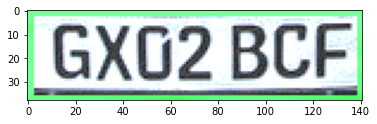

9:17: W291 trailing whitespace
12:80: E501 line too long (108 > 79 characters)
15:1: W293 blank line contains whitespace
19:23: E225 missing whitespace around operator
20:27: E225 missing whitespace around operator


In [185]:
google_speed = 0
google_accuracy = 0
google_speed_counter = 0
google_accuracy_counter = 0
for i in range(42):
    print("picture: "+str(i+1))
    if plates[i][0] == "skip":
        print("skipping..")
        continue 
    pic = str(i+1).zfill(2)
    pic_path = path + pic + ".jpg"
    result = Detect_And_Read_Plates(pic_path, model, cfg, debug=False, Tesseract=False, plate_num=plates[i])
    google_speed += result[0][0]
    google_speed_counter += result[0][1]
    
    google_accuracy += result[1][0]
    google_accuracy_counter += result[1][1]
    print()
print("Average time: "+ str(google_speed/google_speed_counter))
print("Average accuracy: "+ str(google_accuracy/google_accuracy_counter))

picture: 1
[] 0.008
[] 0.002
picture: 2
[] 0.003
picture: 3
[] 0.004
picture: 4
[] 0.008
picture: 5
[] 0.002
[] 0.004
picture: 6
[] 0.002
[{'plate': '9XHP78', 'confidence': 86.826912, 'matches_template': 0, 'plate_index': 0, 'region': '', 'region_confidence': 0, 'processing_time_ms': 47.062, 'requested_topn': 25, 'coordinates': [{'x': 46, 'y': 163}, {'x': 150, 'y': 153}, {'x': 153, 'y': 176}, {'x': 49, 'y': 187}], 'candidates': [{'plate': '9XHP78', 'confidence': 86.826912, 'matches_template': 0}, {'plate': '09XHP78', 'confidence': 82.900482, 'matches_template': 0}, {'plate': 'D9XHP78', 'confidence': 82.326912, 'matches_template': 0}, {'plate': 'I9XHP78', 'confidence': 82.218231, 'matches_template': 0}, {'plate': '9XHP7B', 'confidence': 78.728119, 'matches_template': 0}, {'plate': '9XHP7', 'confidence': 78.574524, 'matches_template': 0}, {'plate': '9XMP78', 'confidence': 76.236748, 'matches_template': 0}, {'plate': '09XHP7B', 'confidence': 74.801682, 'matches_template': 0}, {'plate': '0

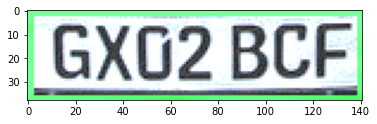

7:17: W291 trailing whitespace
10:80: E501 line too long (100 > 79 characters)
11:1: W293 blank line contains whitespace
14:23: E225 missing whitespace around operator


In [30]:
open_speed = 0
open_speed_counter = 0
for i in range(42):
    print("picture: "+str(i+1))
    if plates[i][0] == "skip":
        print("skipping..")
        continue 
    pic = str(i+1).zfill(2)
    pic_path = path + pic + ".jpg"
    result = Detect_And_Read_Plates(pic_path, model, cfg, debug=False, OCR='O', plate_num=plates[i])
    
    open_speed += result[0][0]
    open_speed_counter += result[0][1]
print("Average time: "+ str(open_speed/open_speed_counter))

# Bronnen
Brownlee, J. (2020, September 1). How to Train an Object Detection Model with Keras. Machine Learning Mastery. https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/

Matterport, M. (2018, March 20). matterport/Mask_RCNN. GitHub. https://github.com/matterport/Mask_RCNN

Theophilebuyssens, T. (2020, January 28). License Plate Recognition using OpenCV, YOLO and Keras. Medium. https://medium.com/@theophilebuyssens/license-plate-recognition-using-opencv-yolo-and-keras-f5bfe03afc65